In [1]:
# Necessary imports
import numpy as np                                  # numpy (linear algebra and more)
import cvxpy as cp                                  # cvxpy (convex optimization solver)
from scipy.signal import butter, lfilter, freqz     # scipy.signal (low-pass filter)
import matplotlib.pyplot as plt                     # matplotlib (to plot stuff)

# Identification of linear systems

Identification of a linear system from input-output data -- an easy task (but we can make it difficult).

Topics addressed in this module:

- An overview of system identification
- Least-squares and reguarlized variants
- Model validation and selection
- Pre-filtering of I/O data

Recommended literature:

1. This is an excellent startin point: L. Ljung, *System Identification: Theory for the User*, Prentice-Hall, Upper Saddle River, New Jersey, 1999
2. An accessible introduction to system identification: K.J. Keesman, *System identification: an introduction*, Springer, 2011
3. A more modern approach to system identification using kernel methods: G. Pillonetto, F. Dinuzzo, T. Chen, G. De Nicolao and L. Ljung, *Kernel methods in system identification, machine learning and function estimation: a survey*, Automatica 50(1):657-682, 2014
4. P. Van den Hof, *Closed-loop issues in system identification*, Annual Reviews in Control 22:173-186, 1998



### System identification: objectives

The main objective of system identification is to infer information about the dynamics of a system using input-output data combined with, when available, prior information about the system.

Such prior information can be the knowledge that the system is linear (of known or unknown order), that it possesses a particular structure. As an example, assume we know that a system has the following structure
$$
\begin{align}
        x(t+1) 
{}={}&
        \begin{bmatrix}
        \alpha & 1\\
        0 & 2\alpha
        \end{bmatrix}
        x(t)
        +
        \begin{bmatrix}
        1
        \\
        0
        \end{bmatrix}
        u(t)
        +
        w(t),
\\
        y(t)
{}={}&
        x(t),
\end{align}
$$
where $x$ is the state of the system, $u$ is the input and $w$ is an iid random noise.

Then, a typical system identification task would be to determine $\alpha$ using input-output data.

There exist cases in which we have no information about the system dynamics other than the fact that it is linear, that is,
$$
\begin{align}
        x(t+1) 
{}={}&
        A
        x(t)
        +
        B
        u(t)
        +
        G
        w(t)
\\
        y(t)
{}={}&
        x(t),
\end{align}
$$
for matrices $A$, $B$ and $G$ of appropriate dimensions, where $w(t)$ is an iid random noise term. In such a case, our task consists in determining these matrices $A$, $B$ and $G$. Then our task would be to determine these matrices $A$, $B$ and $G$.

More generally, the system dynamics may by described by a set of nonlinear equations with either known or unknown structure. Here we focus on linear time-invariant dynamical systems.




### System dynamics

We have a system with structure 
$$
    y(k) 
{}={} 
        \sum_{i=1}^{n}\alpha_i y(k-i) 
{}+{}
        \sum_{i=1}^{m}\beta_{i} u(k-i) 
{}+{} 
        e(k),
$$ 
where $\alpha=(\alpha_1,\ldots, \alpha_n)$ and $\beta=(\beta_1,\ldots, \beta_m)$.

Define $\theta_\star=(\alpha^{\top}, \beta^{\top})^{\top}$ to be the vector of the true parameters of the system. 

Then, for $k=\max(m,n),\ldots,N$ we have $y(k) = \begin{bmatrix}y(k-1)&\cdots&y(k-n)&u(k-1)&\cdots&u(k-m)\end{bmatrix}\theta$.

Therefore, assuming that $n>m$ -- as it is typically the case, we have

$$
    \begin{bmatrix}
    y(n)\\
    y(n+1)\\
    \vdots\\
    y(N)
    \end{bmatrix}
{}={}
    \underbrace{
    \begin{bmatrix}
    y(n-1) & \cdots & y(0) & u(n-1) & \cdots & u(n-m)\\
    y(n) & \cdots & y(1) & u(n) & \cdots & u(n-m+1)\\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots\\
    y(N-1) & \cdots & y(N-n+1) & u(N) & \cdots & u(N-m+1)\\
    \end{bmatrix}}_{{}:={} \Phi_N}
    \theta_\star
{}+{}
    E,
$$
where $y(0), \ldots, y(n-1)$ are fixed and $E$ is the corresponding error term.

For the time being, we shall assume that the model structure, that is, the lengths $n$ and $m$ are known.


We now introduce the following class for linear systems:

In [2]:
class linear_system:
    """Linear system class
    Defines a linear system of the form 
         y(t) = a[0]*y(t-1) + ... + a[n]*y(t-n) 
                + b[0]*u(t-1) + ... + b[m] * y(t-m)
                + e(t)
    with n > m, where
     y  :   system output
     u  :   input
     e  :   iid Gaussian noise with average 0 and variance `sigma`
    """
    
    def __init__(self, alpha, beta, sigma=0):
        """Constructor
        Syntax: ls = linear_system(alpha, beta, sigma), 

        where
         alpha  :  coefficients of y
         beta   :  coefficients of u
         sigma  :  variance of e
        """
        self._alpha = alpha
        self._beta = beta
        self._theta_star = np.asmatrix(np.append(alpha,beta)).transpose();
        self._sigma = sigma
        
    def simulate(self, init_condition, u_input_signal):
        """Simulates the linear system
        Produces a simulation of the linear system using a 
        given input signal
        """
        init_size = init_condition.size
        if (init_size < self.get_order()):
            raise Exception("Short initial condition!")
        num_data = u_input_signal.size
        y_output_signal = np.zeros(num_data+1)
        y_output_signal[:init_condition.size] = init_condition
        for t in range(1, num_data-init_size+2):
            y_t = 0.
            dt = t + init_size - 1
            for i in range(0, min(self._alpha.size, dt)):
                y_t += self._alpha[i]*y_output_signal[dt-i-1]
            for i in range(0, min(self._beta.size, dt)):
                y_t += self._beta[i]*u_input_signal[dt-i-1]
                
            y_output_signal[dt] = y_t + np.random.normal(0, self._sigma);
        return y_output_signal
        
        
    def get_phi(self):
        return self._phi
    
    def get_parameters(self):
        """System parameters
        Returns the system parameters `alpha` and `beta` in a 
        vector theta = [alpha
                        beta ]
        """
        return self._theta_star  
    
    def get_n(self):
        return self._alpha.size
    
    def get_m(self):
        return self._beta.size
    
    def get_order(self):
        return np.max([self.get_n(), self.get_m()])
    

excitation u = [ 0.          0.58509727  0.94898462  0.95408578]
response   y = [ -4.           5.          11.08509727  -3.50846674 -22.97034214]


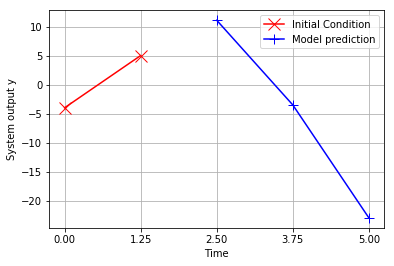

In [3]:
# -- Example: y[t] = 0.5 * y[t-1] - 2.0 * y[t-2] + u[t-1] 
alpha_xmpl = np.array([0.5, -2.0])
beta_xmpl  = np.array([1.0])
mdl_xmpl   = linear_system(alpha_xmpl, beta_xmpl) 

# Say we need to simulate the system with initial conditions y[0] = -4 and y[1] = 5
# and using the signal u[t] = sin(0.5 * t) for t = 0,...,T-1 with T=5
y_init_xmpl = np.array([-4, 5])
t_max_xmpl  = 5
time_xmpl   = np.linspace(0, t_max_xmpl, t_max_xmpl)
u_xmpl      = np.sin(0.5*time_xmpl[:-1])


Y_xmpl = mdl_xmpl.simulate(y_init_xmpl, u_xmpl)

print("excitation u = " + str(u_xmpl))
print("response   y = " + str(Y_xmpl))

plt.plot(time_xmpl[0:y_init_xmpl.size], Y_xmpl[0:y_init_xmpl.size], marker='x', color='r', markersize=12)
plt.plot(time_xmpl[y_init_xmpl.size:], Y_xmpl[y_init_xmpl.size:], color='b', marker='+', markersize=10)
plt.legend(['Initial Condition','Model prediction'])
plt.xlabel('Time')
plt.ylabel('System output y')
plt.grid()
plt.xticks(time_xmpl)
plt.show()

### Generation of I/O data

Let us generate data from that system using $e(t)\sim \mathcal{N}(0,\sigma^2)$ and the input signal $u(k) = c  \sin(k)$

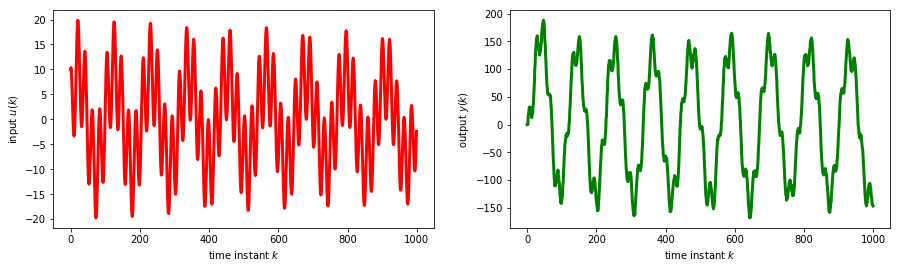

In [4]:
#### --- Construct a linear system    
alpha = np.array([0.2,0.6,0.15]);
beta  = np.array([0.5, 1.2]);    
sigma = 2.5
actual_system = linear_system(alpha, beta, sigma);


# --- Construct an input signal
num_data = 1000
time_span = np.linspace(0, num_data, num_data)
c = 10
u = c*(np.cos(0.3*time_span[:-1])                                       \
    + np.sin(0.08*time_span[:-1]**0.95))                                \
        *np.exp(-0.00015*time_span[:-1])


# --- Simulate the system
y0    = np.array([0,0,0])
y     = actual_system.simulate(y0, u)

# --- PLOT the input/output data
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(time_span[:-1],u, linewidth=3, color='red')
plt.xlabel('time instant $k$')
plt.ylabel('input $u(k)$')
plt.subplot(122)
plt.plot(time_span,y, linewidth=3, color='green')
plt.xlabel('time instant $k$')
plt.ylabel('output $y(k)$')
plt.show()

### Construction of least-squares problem

We now solve the following regularized least-squares problem:

$$
\operatorname*{Minimize}_{\theta{}\in{}\mathbb{R}^{n+m}} \|\Phi\theta - Y\|^2 + R(\theta)
$$

Typical regularizers are:

- $R(\theta) = \lambda \theta^\top P^{-1} \theta$, for a matrix $P$. This is known as [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) or ridge regression. It aims at avoiding multiple solutions of the non-regularized least-squares problem by favoring parameters with small norm.
- $R(\theta) = \lambda \|\theta\|_1$, which is used to enforce sparsity in $\theta$. This is often referred to as [LASSO](https://en.wikipedia.org/wiki/Tikhonov_regularization). The resulting vector $\theta^\star$ (the minimizer of the above regularized least-squares problem) will be sparser as we increase $\lambda$. A *debiasing* step is recommended after solving an $\|{}\cdot{}\|_1$-regularized least-squares problem: 
- $R(\theta) = \lambda_1 \|\theta\|_1 + \lambda_2\|\theta\|_2^2$ is known as the [elastic net](https://en.wikipedia.org/wiki/Regularized_least_squares#Elastic_net) regularization. This regularizer generalizes both LASSO and ridge regression. The quadratic penalty term makes the loss function strictly convex, and it therefore has a unique minimum. The elastic net is used to select groups of correlated variables.

And many other...

The following class will be used to identify the given system from data

In [5]:
class linear_system_identifier:
    """LTI system identification class
    This class is used to identify systems of a particular structure
    given input-output signals (u(t), y(t))
    """
    def __init__(self, input_data, output_data, n, m):
        """Constructor
        This is a constructor for `linear_system_identifier`
        Syntax: 
        ssid = linear_system_identifier(input_signal, output_signal, n, m)
        
        where
        input_signal    :   input signal
        output_signal   :   output signal
        n               :   number of past y's affecting the output
        m               :   number of past u's affecting the output
        
        Parameters `n` and `m` determine the model order.
        
        Note: If `input_data` is of lenth `N`, output_data must be of 
              length (at least) `N + 1`
        """
        self._u = input_data
        self._y = output_data[:input_data.size+1]
        self._n = n
        self._m = m
        
    def get_n(self):
        return self._n
    
    def get_m(self):
        return self._m
        
    def _inverse_range(self, low, high):
        return np.arange(high, low-1, -1)

    def construct_phi(self):
        num_data = self._u.size + 1        
        num_rows_phi = num_data - self._n
        num_cols_phi = self._n + self._m
        phi = np.zeros([num_rows_phi, num_cols_phi])
        for i_row_phi in range(0, num_rows_phi):
            phi[i_row_phi][:self._n] =                                        \
                    self._y[                                                  \
                            self._inverse_range(                              \
                                    i_row_phi, i_row_phi + self._n - 1)       \
                            ]
            phi[i_row_phi][self._n:] =                                        \
                    self._u[                                                  \
                            self._inverse_range(                              \
                                    i_row_phi + 1, i_row_phi + self._m)       \
                            ]          
        return np.matrix(phi)
    
    def estimate_params_rls(self, lam=0, verbose=False,                       \
                              regularizer=cp.sum_squares):
        """Estimates the system parameters by ReLS
        Solves a regularized least squares problem to determine the system
        parameters; the ReLS problem is of the form
        
        Minimize_theta |Phi * theta - Y|^2 + lambda * R(theta)
        
        Syntax:
        ssid.estimate_params_rls(lam=10, regularizer=cp.norm1, verbose=False)
        
        where
        ssid         :  object of type `linear_system_identifier`
        lam          :  regularization parameters (default = 0)
        regularizer  :  regularizer function
        verbose      :  whether to print out solver details (default=False)
        """
        phi      = self.construct_phi()
        theta    = cp.Variable(phi.shape[1])        
        cost_fun = cp.sum_squares(phi*theta - self._y[self._n:])              \
                   + lam * regularizer(theta)
        prob  = cp.Problem(cp.Minimize(cost_fun))
        prob.solve(verbose=verbose, solver="SCS")
        alpha = theta.value[:self._n]
        beta = theta.value[self._n:]        
        return linear_system(np.array(alpha), np.array(beta), 0)

In [6]:
## --- Identify the system using I/O data
n_mdl = 3                                                       # model order n
m_mdl = 2                                                       # model order m
identifier     = linear_system_identifier(                      \
                                          u[:-1], y,            \
                                          m=m_mdl,              \
                                          n=n_mdl)              # system identifier 
sys_identified = identifier.estimate_params_rls(lam=10)         # identify system
prms = sys_identified.get_parameters()                          # get system parameters
print("alpha :\n " + str(prms[:n_mdl]))                         # print alpha
print("beta  :\n " + str(prms[n_mdl:]))                         # print beta

alpha :
 [[ 0.20024738]
 [ 0.56720056]
 [ 0.18143007]]
beta  :
 [[ 0.43350534]
 [ 1.30088392]]


### Evaluation and Model Generalization Capacity

Several approaches exist in order to evaluate a model $M(p)$, where $p$ are its tuning parameters (e.g., above $p=(n,m, \lambda)$), in order to select the best model $M(p^\star)$, that is, the model that is likely to perform better than other models.

Criteria that are taken into account in model selection include, but are not limited to the following:

- Goodness of fit against a test set (which has not been used to train the model)
- (Occam's razor) Complexity (models of too high complexity are often undesired, although they might perform very well)
- Bias and variance of errors

Here we shall mainly focus on the first one - the goodness of fit against an external set of data. Assume the system has been actuated with a signal $(u^{\text{test}}(t))_{t=0}^{M}$ and has produced an output signal $(y^{\text{test}}(t))_{t=0}^{M}$.

Let us denote by $\hat{y}(t+k\mid t)$ the model prediction that time $t+k$ using information for $y$ up to time $k$. 

The prediction error is 

$$
e(t+k\mid t) = \hat{y}(t+k\mid t) - y^{\text{test}}(t+k).
$$

These are illustrated in the following figure:

<img src="fig1.png" >


Two very commonly used metrics are the *mean absolute error* (over the test set), that is

$$
\mathrm{MAE} = \mathrm{mean}(\{e(t+k\mid t)\}_{k=0}^{M})
$$

and the *root mean squared error*, that is

$$
\mathrm{RMS} = \mathrm{rms}(\{e(t+k\mid t)\}_{k=0}^{M})
$$

In [7]:
## Model evaluation
num_data_test = 100
time_span_test = np.linspace(0, num_data_test, num_data_test)
u_test = 5 * np.sin(0.5*time_span_test)

init_condition = np.zeros(shape=(3))

def forecast_errors(u_test, actual_system, sys_identified, init_condition):
    y_actual_test = actual_system.simulate(init_condition, u_test)
    y_mdl_test    = sys_identified.simulate(init_condition, u_test)
    errors = y_actual_test - y_mdl_test
    return errors
           
errors = forecast_errors(u_test, actual_system, sys_identified, init_condition)

abs_err = np.abs(errors)
sqr_err = np.square(abs_err)

MAE  = np.sum(abs_err)
RMSE = np.sqrt(np.average(sqr_err))

print('MAE     = {0:.2f}'.format(MAE))
print('RMSE    = {0:.2f}'.format(RMSE))


MAE     = 398.27
RMSE    = 4.98


Additionally, we define the following index:

$$
        F_k 
{}={}
        100
        \left(
            1
        {}-{}
            \sqrt{
                    \frac
                    {
                        \sum_{t} e(t+k\mid t)^2
                    }
                    {
                        \sum_{t} (y^{\text{test}}(t) - \bar{y}^{\text{test}} )^2
                    }
            }
        \right)
$$

$F_k$ concerns $k$-step-ahead predictions and in the numerator, the term $\sum_{t} e(t+k\mid t)^2$ quantifies the total $k$-step-ahead prediction error in the test set.

In [10]:
num_data_test = 100
time_span_test = np.linspace(0, num_data_test, num_data_test)
U = 5 * np.sin(0.7 * time_span_test)
Y = actual_system.simulate(init_condition, u_test)

# -- we shall now evaluate our model using the test set (U, Y)
def predictor(model, U, Y, t, prediction_length):
    n = model.get_n()
    order = model.get_order()
    model.simulate()

### Model Selection

We may use the above statistics to evaluate a collection of models and choose the best among them.

As an exercise, for the above problem let us assume we know that $m=2$ and we need to determine the best value for $n$ and $\lambda$ using $\|{}\cdot{}\|_1$ as a regularizer.


In [9]:
# Model selection
num_data_test = 200
time_span_test = np.linspace(0, num_data_test, num_data_test)
u_test = 5 * np.sin(0.5*time_span_test)

mdl_eval_cache = np.empty(shape=(0,3))
mdl_sys_cache  = np.empty(shape=(0,1))

for n_ in range(2,5):
    for l_ in np.logspace(0.1, 4.5, num=10):
        identifier = linear_system_identifier(u_test, y, m=2, n=n_)
        sys_identified = identifier.estimate_params_rls(                 \
                                    regularizer=cp.norm1,                \
                                    lam=l_,                              \
                                    verbose=False)
        errors = forecast_errors(u_test, actual_system, sys_identified, init_condition)
        abs_err = np.abs(errors)
        sqr_err = abs_err**2
        MAE  = np.sum(abs_err)
        RMSE = np.sqrt( np.average(sqr_err) )
        F = MAE
        F_prec = np.percentile(F, 95)
        eval_data_current = np.array([n_, l_, F_prec])
        mdl_sys_cache     = np.vstack([mdl_sys_cache, sys_identified]);
        mdl_eval_cache    = np.vstack([mdl_eval_cache, eval_data_current])
    

IndexError: index 200 is out of bounds for axis 1 with size 200

In [334]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111, projection='3d')

imax = np.argmin(mdl_eval_cache[:,2])
n_max = mdl_eval_cache[imax, 0]
l_max = mdl_eval_cache[imax, 1]
fit_max = mdl_eval_cache[imax, 2]

print('Best RMSE           = {0:.2f}'.format(fit_max))
print('n*                  = {0:.0f}'.format(n_max) )
print('lam*                = {0:.1f}'.format(l_max) )


ax.scatter(mdl_eval_cache[:,0], np.log10(mdl_eval_cache[:,1]), mdl_eval_cache[:,2])
ax.set_xlabel('n (model order)')
ax.set_ylabel('log(lambda)')
ax.set_zlabel('F')
plt.xticks(np.array([2,3,4]))
plt.yticks(np.array([0, 2, 4]))
plt.show()

ValueError: attempt to get argmin of an empty sequence

### Improvement: filtering the I/O data

In order the improve the modelling performance, we may do [the following](https://people.mech.kuleuven.be/~jswevers/h04x3a/lecture_c2_c3.pdf):

- Excite the system only within the frequency band of interest
- Filter the output using a low-pass filter (e.g., a Butterworth LPF)

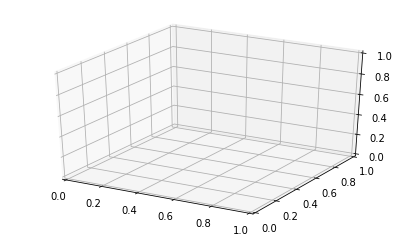

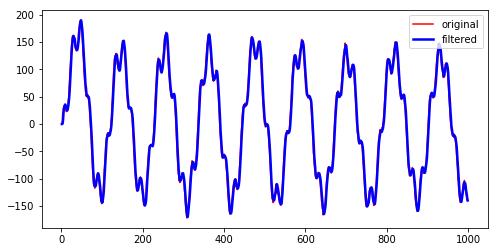

In [335]:
def butterworth_lowpass(cutoff, fs, order=5):
    b, a = butter(order, 2 * cutoff / fs, btype='low', analog=False)
    return b, a

def butterworth_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butterworth_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order  = 6      # filter order
fs     = 10     # sample rate, Hz
cutoff = 3.0    # desired cutoff frequency of the filter, Hz

# Obtain the filter coefficients
b, a = butterworth_lowpass(cutoff, fs, order)

# Filter y
y_filt = butterworth_lowpass_filter(y, cutoff, fs, order)

plot_time = np.min([1000, num_data-1]) 
plt.figure(figsize=(8, 4))
plt.plot(time_span[1:plot_time], y[1:plot_time], color='r')
plt.plot(time_span[1:plot_time], y_filt[1:plot_time], linewidth=2.5, color='b')
plt.legend(['original', 'filtered'])
plt.show()

### Statistical tests

Have we derived a model which performs well against test data (it has a high fit), we may/should ask whether this is simple enough (whether equally high performance may be obtained by a simpler model), whether the modeling residuals are normally distributed or what their distribution might be and whether the innovations $e(t)$ are independent.


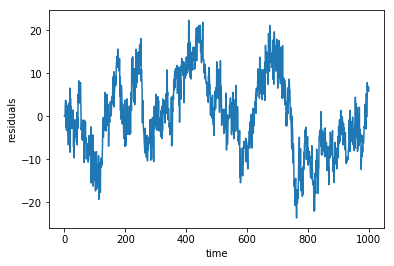

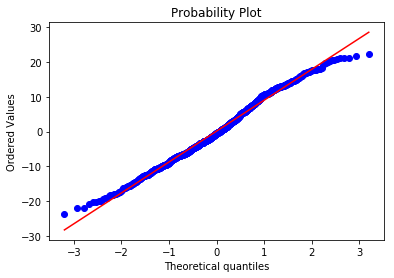

KstestResult(statistic=0.42138484205510685, pvalue=0.0)


In [339]:
# Select model to test its residuals...
#best_model = mdl_sys_cache[imax,0]
best_model = actual_system

# Pick an input signal
num_data_test  = 1000
time_span_test = np.linspace(0, num_data_test, num_data_test)
u_test         = 5 * np.sin(0.5*time_span_test)

y_actual_test = actual_system.simulate(np.array([0,0,0]), u_test)
y_mdl_test    = best_model.simulate(np.array([0,0,0]), u_test)

residuals    = y_actual_test - y_mdl_test

plt.plot(time_span_test, residuals[:-1])
plt.xlabel('time')
plt.ylabel('residuals')
plt.show()


# --- QQ plot of modeling residuals
#     We want to see (quite literally) whether the residuals
#     come from a normal distribution
import pylab 
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

# --- Hypothesis testing: are the residuals normally distributed?
#     We use the Kolmogorov-Smirnov statistical test
print(stats.kstest(residuals, 'norm'))


## Endnotes

1. Not always is it the case that we are able to experiment (indefinitely) with a dynamical system. It is often the case that we may only obtain a certain amount of open-loop input-output data. In such cases, [cross-validation] approaches may be more fit (no pun intended).
2. Often in practice we encounter situations where a system cannot be excitated in open loop due to technical constraints and/or because it is open-loop unstable. In closed-loop settings, the excitation is a function of the system output.  These situations call for closed-loop system identification methodologies which are not covered here.

## Further reading

- AR(I)MA(X) models
- (Partial) autocorrelation functions - uncorrelatedness tests
- Maximum likelihood estimation
- Subspace identification